# Using Keras' Pretrained Neural Networks for Visual Similarity Recommendations

Explore an unsupervised, deep learning-based model. You'll find that the implementation is fairly simple with remarkably promising results which is almost a smack in the face to all of that effort put in earlier.
We are going to build a model-to-model recommender using thumbnail images for models as our input and the visual similarity between models as our recommendation score. I was inspired to do this after reading Christopher Bonnett's post on product classification, so we will follow a similar approach.

Since our goal is to measure visual similarity, we will need to generate features from our images and then calculate some similarity measure between different images using said features. Back in the day, maybe one would employ fancy wavelets or SIFT keypoints or something for creating features, but this is the Era of Deep Learning and manual feature extraction is for old people.

Staying on-trend, we will use a pretrained neural network (NN) to extract features. The NN was originally trained to classify images among 1000 labels (e.g. "dog", "train", etc...). We'll chop off the last 3 fully-connected layers of the network which do the final mapping between deep features and class labels and use the fourth-to-last layer as a long feature vector describing our images.

Thankfully, all of this is extremely simple to do with the pretrained models in Keras. Keras allows one to easily build deep learning models on top of either Tensorflow or Theano. Keras also now comes with pretrained models that can be loaded and used. For more information about the available models, visit the Applications section of the documentation. For our purposes, we'll use the VGG16 model because that's what other people seemed to use and I don't know enough to have a compelling reason to stray from the norm.

Our task is now as follows:

1. Load and process images
2. Feed images through NN.
3. Calculate image similarities.
4. Recommend models!
## Load and process images
The first step, which we won't go through here, was to download all of the image thumbnails. There seems to be a standard thumbnail for each Sketchfab model accessible via their API, so I added a function to the rec-a-sketch crawl.py script to automate downloading of all the thumbnails.
Let's load in our libraries and take a look at one of these images.

In [1]:
import sys
import requests
import os
import glob
import pickle
import time

from IPython.display import display, Image, HTML
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix as little_matrix
import skimage.io

sys.path.append('../')

Using TensorFlow backend.


In [3]:
file = './img/0fb30f82-d82a-49a2-850a-6bebcb9137f2.jpg'
img = skimage.io.imread(file)

In [4]:
img.shape

(420, 300, 3)

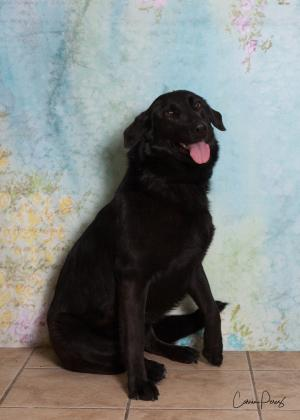

In [5]:
Image(filename=file) 

In [6]:
img = kimage.load_img(file, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


We see that the image can be represented as a 3D matrix through two spatial dimensions (200 x 200) and then a third RGB dimension. We have to do a couple of preprocessing steps before feeding an image through the VGG16 model. The images must be resized to 224 x 224, the color channels must be normalized, and an extra dimension must be added due to Keras expecting to recieve multiple models. Thankfully, Keras has built-in functions to handle most of this.

We can now load our model in and try feeding the image through.
(VGG16 model for Keras)[https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3]
This is the Keras model of the 16-layer network used by the VGG team in the ILSVRC-2014 competition.

It has been obtained by directly converting the Caffe model provived by the authors.

Details about the network architecture can be found in the following arXiv paper:

Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556

In [7]:
# image_top=False removes final connected layers
model = VGG16(include_top=False, weights='imagenet')

In [8]:
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


We will later have to flatten the output of the model into a long feature vector. One thing that should be noted is the time that it takes to run a single model though the NN on my 4-core machine

In [9]:
%%timeit -n25
pred = model.predict(x)

206 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)


### Feed images through NN
With our set of valid model IDs in hand, we can now run through the long process of loading in all of the image files, preprocessing them, and running them through the VGG prediction. This takes a long time, and certain steps blowup memory. I've decided to batch things up below and include some print statements so that one can track progress. Beware: this takes a long time!

In [10]:
directory='img'
items=[]
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        items.append(filename)

idx_to_mid = {}
batch_size = 25
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(items)
print(total_max)
n_dims = pred.ravel().shape[0]
px = 224
print(n_dims)

# Initialize predictions matrix
preds = little_matrix((len(items), n_dims))

import PIL

while min_idx < total_max - 1:
    t0 = time.time()
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        print(i)
        item = items[i]
        idx_to_mid[i] = item
        
        image='./'+ directory +'/'+item
        img = kimage.load_img(image, target_size=(px, px))
        img_array = kimage.img_to_array(img)
               
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
            
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))

2137
25088
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
24: 0.004045406977335612
Preprocess input
0.007758140563964844
Predicting
5.239943981170654
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
48: 0.0019179582595825195
Preprocess input
0.007069826126098633
Predicting
5.200374126434326
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
72: 0.0012811819712320964
Preprocess input
0.007360935211181641
Predicting
5.168432950973511
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
96: 0.0008757164080937704
Preprocess input
0.00737309455871582
Predicting
5.207158088684082
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
120: 0.0008204102516174317
Preprocess input
0.006979942321777344
Predicting
5.188493013381958
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
144: 0.000575631856918335
Preprocess in

5.235472917556763
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1032: 8.082944293354833e-05
Preprocess input
0.0073740482330322266
Predicting
5.223895072937012
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1056: 7.975259513565989e-05
Preprocess input
0.007450103759765625
Predicting
5.244088172912598
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1080: 8.704353261876989e-05
Preprocess input
0.007371187210083008
Predicting
5.236044883728027
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1104: 7.957695187001988e-05
Preprocess input
0.007534027099609375
Predicting
5.243376970291138
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1

5.308498859405518
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1920: 4.545735816160838e-05
Preprocess input
0.007372617721557617
Predicting
5.332495927810669
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1944: 4.757554442794235e-05
Preprocess input
0.007040739059448242
Predicting
5.3353540897369385
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1968: 4.8137292629334986e-05
Preprocess input
0.0071239471435546875
Predicting
5.339069843292236
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1992: 4.787952545656258e-05
Preprocess input
0.00710606575012207
Predicting
5.389534950256348
1992
1993
1994
1995
1996
1997
1998
1999
2000
2000: 1.8977046012878418e-05
2001
2002
2003
2004
2005
2

In [11]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [12]:
from keras.models import load_model

In [13]:
# Return a copy of this matrix in Compressed Sparse Row format
# from keras.models import load_model
# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model
# returns a compiled model

# model = load_model('my_model.h5')

preds = preds.tocsr()
# save the model

# Compute cosine similarity
sim = cosine_similarity(preds)

In [14]:
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        thumbs.append(idx_to_mid[x])
        mids.append(idx_to_mid[x])
    return thumbs, mids

def display_thumbs(thumbs, mids, N=5):
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 300px; margin: 0px; \
                  float: left; border: 1px solid black; display:inline-block' \
                  src='./img/{}' /></a>"
    images = "<div class='line' style='max-width: 1024px; display: block;'>"
    display(HTML('<font size=5>'+'Input Model'+'</font>'))
    link = './'+ directory +'/{}'.format(mids[0])
    url = thumbs[0]
    display(HTML(thumb_html.format(link, url)))
    display(HTML('<font size=5>'+'Similar Models'+'</font>'))

    for (url, mid) in zip(thumbs[1:N+1], mids[1:N+1]):
        link = './'+ directory +'/{}'.format(mid)
        images += thumb_html.format(link, url)

    images += '</div>'
    display(HTML(images))


In [30]:
import pprint
# pprint.pprint(idx_to_mid)
# print(sim)
display_thumbs(*get_thumbnails(sim, 290, idx_to_mid, N=14), N=14)